In [30]:
import random
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import cloudpickle as cpkl
from pathlib import Path
import numpy as np
import datetime
from datetime import timedelta
from functools import reduce
from fbprophet import Prophet
import multiprocessing as mp
from itertools import repeat
from joblib import Parallel, delayed
import calendar
%matplotlib inline

In [31]:
script_name='prophet_item_store'
train_pkl_file = 'input/train_pkl'
test_pkl_file = 'input/test_pkl'
train,transactions,stores,oil,items,holidays_events = cpkl.loads(open(train_pkl_file,'rb').read())

In [32]:
big_bang = datetime.date(2016,5,31)
maxdate = datetime.date(2017,8,31)
train = train.loc[train.date>big_bang,["date","store_nbr","item_nbr","unit_sales","onpromotion"]]
#train.loc[:, "onpromotion"].fillna(False, inplace=True)
transactions = transactions.loc[transactions.date>big_bang]

In [33]:
train.shape

(44661573, 5)

In [34]:
train.onpromotion.unique()

array([False,  True], dtype=bool)

In [35]:
holidays_events.date = pd.to_datetime(holidays_events.date)
holidays_events.date = holidays_events.date.dt.date
all_days = pd.DataFrame({'date':pd.date_range(big_bang,maxdate,freq="D")})
all_days.date = all_days.date.dt.date
all_days['holiday']=0
all_days.loc[all_days.date.isin(holidays_events.date),'holiday']=1
train.date = train.date.dt.date
transactions.date = transactions.date.dt.date
oil.date = oil.date.dt.date

In [36]:
holidays_events = holidays_events[holidays_events.transferred==False]
oil.dcoilwtico.fillna(method='ffill',inplace=True)
oil=oil[oil.date>big_bang]
holidays_events = holidays_events[holidays_events.date>big_bang]
print(oil.head())
import gc
gc.collect()

           date  dcoilwtico
891  2016-06-01       49.07
892  2016-06-02       49.14
893  2016-06-03       48.69
894  2016-06-06       49.71
895  2016-06-07       50.37


47

In [37]:
oil[oil.date>datetime.date(2015,12,31)].dcoilwtico.unique()

array([ 49.07,  49.14,  48.69,  49.71,  50.37,  51.23,  50.52,  49.09,
        48.89,  48.49,  47.92,  46.14,  48.  ,  49.4 ,  48.95,  49.16,
        49.34,  46.7 ,  45.8 ,  47.93,  49.85,  48.27,  49.02,  46.73,
        47.37,  45.22,  45.37,  44.73,  46.82,  44.87,  45.64,  45.93,
        45.23,  44.64,  44.96,  43.96,  43.41,  42.4 ,  42.16,  41.9 ,
        41.13,  41.54,  40.05,  39.5 ,  40.8 ,  41.92,  41.83,  43.06,
        42.78,  41.75,  43.51,  44.47,  45.72,  46.57,  46.81,  48.2 ,
        48.48,  46.8 ,  47.54,  46.29,  46.97,  47.64,  46.32,  44.68,
        43.17,  44.39,  44.85,  45.47,  47.63,  45.88,  46.28,  44.91,
        43.62,  43.85,  43.04,  43.34,  45.33,  46.1 ,  44.36,  45.6 ,
        44.65,  47.07,  47.72,  48.8 ,  48.67,  49.75,  50.44,  49.76,
        50.72,  50.14,  50.47,  50.35,  49.97,  50.3 ,  51.59,  50.31,
        50.61,  50.18,  49.45,  48.75,  48.72,  46.83,  46.66,  45.32,
        44.66,  44.07,  44.88,  45.2 ,  44.62,  43.39,  43.29,  45.86,
      

In [38]:
train.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion
80835467,2016-06-01,1,99197,1.0,False
80835468,2016-06-01,1,103520,2.0,False
80835469,2016-06-01,1,103665,6.0,True
80835470,2016-06-01,1,105574,9.0,False
80835471,2016-06-01,1,105575,16.0,False


In [39]:
#test = cpkl.loads(open(test_pkl_file,'rb').read())

In [40]:
print(train.columns)
#print(test.shape)


Index(['date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion'], dtype='object')


In [41]:
#test = test[["date","store_nbr","item_nbr","onpromotion"]]
#combined = pd.concat([train,test],axis=0,ignore_index=True)

In [42]:
print(train.head())
print(train.tail())

                date  store_nbr  item_nbr  unit_sales  onpromotion
80835467  2016-06-01          1     99197         1.0        False
80835468  2016-06-01          1    103520         2.0        False
80835469  2016-06-01          1    103665         6.0         True
80835470  2016-06-01          1    105574         9.0        False
80835471  2016-06-01          1    105575        16.0        False
                 date  store_nbr  item_nbr  unit_sales  onpromotion
125497035  2017-08-15         54   2089339         4.0        False
125497036  2017-08-15         54   2106464         1.0         True
125497037  2017-08-15         54   2110456       192.0        False
125497038  2017-08-15         54   2113914       198.0         True
125497039  2017-08-15         54   2116416         2.0        False


In [43]:
#te.date = pd.to_datetime(te.date)
train.set_index(pd.DatetimeIndex(train.date),inplace=True)


In [44]:
train.shape

(44661573, 5)

In [45]:
rol20 =pd.DataFrame(train.groupby(['store_nbr','item_nbr'])["unit_sales"].rolling(window=20,freq='1d',min_periods=20//7).mean()).reset_index()
rol30 =pd.DataFrame(train.groupby(['store_nbr','item_nbr'])["unit_sales"].rolling(window=30,freq='1d',min_periods=30//7).mean()).reset_index()
rol40 =pd.DataFrame(train.groupby(['store_nbr','item_nbr'])["unit_sales"].rolling(window=40,freq='1d',min_periods=40//7).mean()).reset_index()
rol60 =pd.DataFrame(train.groupby(['store_nbr','item_nbr'])["unit_sales"].rolling(window=60,freq='1d',min_periods=60//7).mean()).reset_index()
rol90 =pd.DataFrame(train.groupby(['store_nbr','item_nbr'])["unit_sales"].rolling(window=90,freq='1d',min_periods=90//7).mean()).reset_index()
rol180 = pd.DataFrame(train.groupby(['store_nbr','item_nbr'])["unit_sales"].rolling(window=180,freq='1d',min_periods=180//7).mean()).reset_index()


/home/suresh/anaconda3/envs/kag_unitforecast/lib/python3.5/site-packages/pandas/core/groupby.py:1243: FutureWarning: The freq kw is deprecated and will be removed in a future version. You can resample prior to passing to a window function
  return RollingGroupby(self, *args, **kwargs)
/home/suresh/anaconda3/envs/kag_unitforecast/lib/python3.5/site-packages/pandas/core/window.py:709: FutureWarning: The freq kw is deprecated and will be removed in a future version. You can resample prior to passing to a window function
  x = self._shallow_copy(x)


In [46]:
all_rol = rol20.merge(rol30,on=['store_nbr','item_nbr','date'],suffixes=("_20", "_30"))
all_rol = all_rol.merge(rol40,on=['store_nbr','item_nbr','date'],copy=False)
all_rol.rename(columns={'unit_sales':'unit_sales_40'},inplace=True)
all_rol = all_rol.merge(rol60,on=['store_nbr','item_nbr','date'],copy=False)
all_rol.rename(columns={'unit_sales':'unit_sales_60'},inplace=True)
all_rol = all_rol.merge(rol90,on=['store_nbr','item_nbr','date'],copy=False)
all_rol.rename(columns={'unit_sales':'unit_sales_90'},inplace=True)
all_rol = all_rol.merge(rol180,on=['store_nbr','item_nbr','date'],copy=False)
all_rol.rename(columns={'unit_sales':'unit_sales_180'},inplace=True)


In [47]:
all_rol.tail()

,store_nbr,item_nbr,date,unit_sales_20,unit_sales_30,unit_sales_40,unit_sales_60,unit_sales_90,unit_sales_180
64993949,54,2116416,2017-08-12,1.625000,1.625000,1.625000,1.625000,NaN,NaN
64993950,54,2116416,2017-08-13,1.666667,1.666667,1.666667,1.666667,NaN,NaN
64993951,54,2116416,2017-08-14,1.700000,1.700000,1.700000,1.700000,NaN,NaN
64993952,54,2116416,2017-08-15,1.727273,1.727273,1.727273,1.727273,NaN,NaN
64993953,54,2124052,2016-11-27,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
item_means = train.groupby(['item_nbr','date'])['unit_sales'].mean().reset_index()
item_means.set_index(pd.DatetimeIndex(item_means.date),inplace=True)

rol20 =pd.DataFrame(item_means.groupby(['item_nbr'])["unit_sales"].rolling(window=20,freq='1d',min_periods=20//3).mean()).reset_index()
rol30 =pd.DataFrame(item_means.groupby(['item_nbr'])["unit_sales"].rolling(window=30,freq='1d',min_periods=30//3).mean()).reset_index()
rol40 =pd.DataFrame(item_means.groupby(['item_nbr'])["unit_sales"].rolling(window=40,freq='1d',min_periods=40//3).mean()).reset_index()
rol60 =pd.DataFrame(item_means.groupby(['item_nbr'])["unit_sales"].rolling(window=60,freq='1d',min_periods=60//3).mean()).reset_index()
rol90 =pd.DataFrame(item_means.groupby(['item_nbr'])["unit_sales"].rolling(window=90,freq='1d',min_periods=90//3).mean()).reset_index()
rol180 = pd.DataFrame(item_means.groupby(['item_nbr'])["unit_sales"].rolling(window=180,freq='1d',min_periods=180//3).mean()).reset_index()


/home/suresh/anaconda3/envs/kag_unitforecast/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: 'date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.
/home/suresh/anaconda3/envs/kag_unitforecast/lib/python3.5/site-packages/pandas/core/groupby.py:1243: FutureWarning: The freq kw is deprecated and will be removed in a future version. You can resample prior to passing to a window function
  return RollingGroupby(self, *args, **kwargs)
/home/suresh/anaconda3/envs/kag_unitforecast/lib/python3.5/site-packages/pandas/core/window.py:709: FutureWarning: The freq kw is deprecated and will be removed in a future version. You can resample prior to passing to a window function
  x = self._shallow_copy(x)


In [49]:
all_rol = all_rol.merge(rol20,on=['item_nbr','date'],copy=False)
all_rol.rename(columns={'unit_sales':'unit_sales_item_20'},inplace=True)
all_rol = all_rol.merge(rol30,on=['item_nbr','date'],copy=False)
all_rol.rename(columns={'unit_sales':'unit_sales_item_30'},inplace=True)
all_rol = all_rol.merge(rol40,on=['item_nbr','date'],copy=False)
all_rol.rename(columns={'unit_sales':'unit_sales_item_40'},inplace=True)
all_rol = all_rol.merge(rol60,on=['item_nbr','date'],copy=False)
all_rol.rename(columns={'unit_sales':'unit_sales_item_60'},inplace=True)
all_rol = all_rol.merge(rol90,on=['item_nbr','date'],copy=False)
all_rol.rename(columns={'unit_sales':'unit_sales_item_90'},inplace=True)
all_rol = all_rol.merge(rol180,on=['item_nbr','date'],copy=False)
all_rol.rename(columns={'unit_sales':'unit_sales_item_180'},inplace=True)


In [52]:
train.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion
date,,,,,
2016-06-01,2016-06-01,1,99197,1.0,False
2016-06-01,2016-06-01,1,103520,2.0,False
2016-06-01,2016-06-01,1,103665,6.0,True
2016-06-01,2016-06-01,1,105574,9.0,False
2016-06-01,2016-06-01,1,105575,16.0,False


In [56]:
train.reset_index(drop=1,inplace=True)

In [58]:
print(train.head())
print(transactions.head())

         date  store_nbr  item_nbr  unit_sales  onpromotion
0  2016-06-01          1     99197         1.0        False
1  2016-06-01          1    103520         2.0        False
2  2016-06-01          1    103665         6.0         True
3  2016-06-01          1    105574         9.0        False
4  2016-06-01          1    105575        16.0        False
             date  store_nbr  transactions
60284  2016-06-01          1          1898
60285  2016-06-01          2          1961
60286  2016-06-01          3          3239
60287  2016-06-01          4          1391
60288  2016-06-01          5          1333


In [59]:
transactions.set_index(pd.DatetimeIndex(transactions.date),inplace=True)

rol20 =pd.DataFrame(transactions.groupby(['store_nbr'])["transactions"].rolling(window=20,freq='1d',min_periods=20//3).mean()).reset_index()
rol30 =pd.DataFrame(transactions.groupby(['store_nbr'])["transactions"].rolling(window=30,freq='1d',min_periods=30//3).mean()).reset_index()
rol40 =pd.DataFrame(transactions.groupby(['store_nbr'])["transactions"].rolling(window=40,freq='1d',min_periods=40//3).mean()).reset_index()
rol60 =pd.DataFrame(transactions.groupby(['store_nbr'])["transactions"].rolling(window=60,freq='1d',min_periods=60//3).mean()).reset_index()
rol90 =pd.DataFrame(transactions.groupby(['store_nbr'])["transactions"].rolling(window=90,freq='1d',min_periods=90//3).mean()).reset_index()
rol180 = pd.DataFrame(transactions.groupby(['store_nbr'])["transactions"].rolling(window=180,freq='1d',min_periods=180//3).mean()).reset_index()


/home/suresh/anaconda3/envs/kag_unitforecast/lib/python3.5/site-packages/pandas/core/groupby.py:1243: FutureWarning: The freq kw is deprecated and will be removed in a future version. You can resample prior to passing to a window function
  return RollingGroupby(self, *args, **kwargs)
/home/suresh/anaconda3/envs/kag_unitforecast/lib/python3.5/site-packages/pandas/core/window.py:709: FutureWarning: The freq kw is deprecated and will be removed in a future version. You can resample prior to passing to a window function
  x = self._shallow_copy(x)


In [60]:
all_rol = all_rol.merge(rol20,on=['store_nbr','date'],copy=False)
all_rol.rename(columns={'transactions':'transactions_20'},inplace=True)
all_rol = all_rol.merge(rol30,on=['store_nbr','date'],copy=False)
all_rol.rename(columns={'transactions':'transactions_30'},inplace=True)
all_rol = all_rol.merge(rol40,on=['store_nbr','date'],copy=False)
all_rol.rename(columns={'transactions':'transactions_40'},inplace=True)
all_rol = all_rol.merge(rol60,on=['store_nbr','date'],copy=False)
all_rol.rename(columns={'transactions':'transactions_60'},inplace=True)
all_rol = all_rol.merge(rol90,on=['store_nbr','date'],copy=False)
all_rol.rename(columns={'transactions':'transactions_90'},inplace=True)
all_rol = all_rol.merge(rol180,on=['store_nbr','date'],copy=False)
all_rol.rename(columns={'transactions':'transactions_180'},inplace=True)

In [61]:
def add_datepart(df,column_name):
    df[column_name] = pd.to_datetime(df[column_name])
    df["Year"] = df[column_name].dt.year
    df["Month"] = df[column_name].dt.month
    df["Week"] = df[column_name].dt.week
    df["Day"] = df[column_name].dt.day
    
add_datepart(transactions,'date')



In [63]:
print(transactions.head())
transactions.reset_index(drop=1,inplace=True)
print(transactions.head())

                 date  store_nbr  transactions  Year  Month  Week  Day
date                                                                  
2016-06-01 2016-06-01          1          1898  2016      6    22    1
2016-06-01 2016-06-01          2          1961  2016      6    22    1
2016-06-01 2016-06-01          3          3239  2016      6    22    1
2016-06-01 2016-06-01          4          1391  2016      6    22    1
2016-06-01 2016-06-01          5          1333  2016      6    22    1
        date  store_nbr  transactions  Year  Month  Week  Day
0 2016-06-01          1          1898  2016      6    22    1
1 2016-06-01          2          1961  2016      6    22    1
2 2016-06-01          3          3239  2016      6    22    1
3 2016-06-01          4          1391  2016      6    22    1
4 2016-06-01          5          1333  2016      6    22    1


(array([  3.50600000e+03,   1.15540000e+04,   4.41600000e+03,
          1.96800000e+03,   1.07600000e+03,   5.23000000e+02,
          1.31000000e+02,   1.90000000e+01,   8.00000000e+00,
          3.00000000e+00]),
 array([  5.00000000e+00,   8.35200000e+02,   1.66540000e+03,
          2.49560000e+03,   3.32580000e+03,   4.15600000e+03,
          4.98620000e+03,   5.81640000e+03,   6.64660000e+03,
          7.47680000e+03,   8.30700000e+03]),
 <a list of 10 Patch objects>)

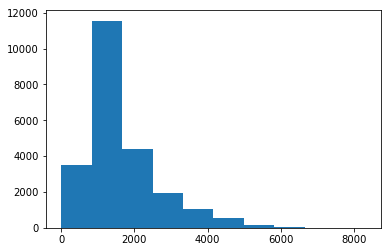

In [64]:
plt.hist(transactions.transactions)

In [66]:
transactions[transactions.transactions==0]

,date,store_nbr,transactions,Year,Month,Week,Day


In [69]:
print(transactions.shape)
print(len(transactions.store_nbr.unique()))
print(len(transactions.date.unique()))

(23204, 7)
54
440


In [70]:
54*440

23760

~500 days are not present across stores durin the time frame

In [104]:
all_days = pd.date_range(start=big_bang,freq="D",end=max(transactions.date))
all_stores = transactions.store_nbr.unique()
all_days = pd.DataFrame({'date':all_days})
all_stores = pd.DataFrame({'store_nbr':all_stores})
all_stores['key'] = 0
all_days['key'] = 0
all_poss_transactions = all_days.merge(all_stores, how='left', on = 'key')
all_poss_transactions.drop('key',1, inplace=True)


In [105]:
all_poss_transactions.shape

(23868, 2)

In [106]:
all_poss_transactions

,date,store_nbr
0,2016-05-31,1
1,2016-05-31,2
2,2016-05-31,3
3,2016-05-31,4
4,2016-05-31,5
5,2016-05-31,6
6,2016-05-31,7
7,2016-05-31,8
8,2016-05-31,9
9,2016-05-31,10


In [107]:
all_poss_transactions = all_poss_transactions.merge(transactions,on=['date','store_nbr'],how="left")

In [108]:
all_poss_transactions.shape

(23868, 3)

In [114]:
all_poss_transactions.transactions.fillna(0,inplace=True)
all_poss_transactions[all_poss_transactions.transactions.isnull()]

,date,store_nbr,transactions


In [115]:
all_poss_transactions.shape

(23868, 3)

In [116]:
print(min(all_poss_transactions.transactions))
print(all_poss_transactions.sort_values('transactions',ascending=False).head())

0.0
            date  store_nbr  transactions
11167 2016-12-23         44        8307.0
11059 2016-12-21         44        7597.0
11223 2016-12-24         46        7528.0
11221 2016-12-24         44        7430.0
11169 2016-12-23         46        7351.0


In [136]:
all_poss_transactions['closed'] = all_poss_transactions.transactions.apply(lambda x : 1 if x==0 else 0)
#transactions = transactions[['date','store_nbr','transactions']]

In [121]:
class elapsed_transactions(object):
    def __init__(self, fld):
        self.fld = fld
        self.last = pd.to_datetime(np.nan)
        self.last_store = 0
        
    def get(self, row):
        if (row.store_nbr != self.last_store):
            self.last = pd.to_datetime(np.nan)
            self.last_store = row.store_nbr
        if (row[self.fld]): self.last = row.date
        return (row.date-self.last).days

def add_elapsed_transactions(df,fld, prefix):
    sh_el = elapsed_transactions(fld)
    df[prefix+fld] = df.apply(sh_el.get, axis=1)

In [140]:
df = all_poss_transactions.copy()
all_poss_transactions.sort_values(['store_nbr','date'],inplace=True)
fld = 'closed'
add_elapsed_transactions(fld, 'After')

In [141]:
all_poss_transactions.groupby('closed').size()

closed
0    23204
1      664
dtype: int64

In [146]:
df.head()

,date,store_nbr,transactions,closed,Afterclosed
0,2016-05-31,1,0.0,1,0
54,2016-06-01,1,1898.0,0,1
108,2016-06-02,1,1637.0,0,2
162,2016-06-03,1,1804.0,0,3
216,2016-06-04,1,1261.0,0,4


In [147]:
df['consecutive_closed'] = df.closed.groupby((df.closed != df.closed.shift()).cumsum()).transform('size') * df.closed


In [148]:
df['consecutive_closed'].unique()

array([  1,   0, 110,  66,   4, 324])

In [158]:
df[df.consecutive_closed==1]

,date,store_nbr,transactions,closed,Afterclosed,consecutive_closed
0,2016-05-31,1,0.0,1,0,1
11232,2016-12-25,1,0.0,1,0,1
11610,2017-01-01,1,0.0,1,0,1
1,2016-05-31,2,0.0,1,0,1
11233,2016-12-25,2,0.0,1,0,1
11611,2017-01-01,2,0.0,1,0,1
2,2016-05-31,3,0.0,1,0,1
11234,2016-12-25,3,0.0,1,0,1
11612,2017-01-01,3,0.0,1,0,1
3,2016-05-31,4,0.0,1,0,1


In [159]:
df[df.consecutive_closed==1]

,date,store_nbr,transactions,closed,Afterclosed,consecutive_closed
0,2016-05-31,1,0.0,1,0,1
11232,2016-12-25,1,0.0,1,0,1
11610,2017-01-01,1,0.0,1,0,1
1,2016-05-31,2,0.0,1,0,1
11233,2016-12-25,2,0.0,1,0,1
11611,2017-01-01,2,0.0,1,0,1
2,2016-05-31,3,0.0,1,0,1
11234,2016-12-25,3,0.0,1,0,1
11612,2017-01-01,3,0.0,1,0,1
3,2016-05-31,4,0.0,1,0,1
